In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
tf.random.set_seed(42)

In [4]:
data_path = 'data/'

train_csv_file_path = data_path + 'train_ship_segmentations_v2_clean.csv'
train_image_path = data_path + 'train_v2/'

In [5]:
def load_csv(path):
    return tf.data.experimental.make_csv_dataset(
        path,
        batch_size=1, # required
        column_names=['ImageId', 'EncodedPixels'],
        num_epochs=1,
        shuffle=False,
    )

train_csv = load_csv(train_csv_file_path)

# for batch in train_csv.take(1):
#     print(batch)

2024-02-11 13:21:57.345972: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-11 13:21:57.345991: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-11 13:21:57.345997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-11 13:21:57.346029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-11 13:21:57.346042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
IMG_HEIGHT = 768
IMG_WIDTH = 768

@tf.function
def process_img(file):
    img = tf.io.read_file(train_image_path + file)
    img = tf.io.decode_jpeg(img, channels=3)
    return img

@tf.function
def decode_label_mask(encoded_pixels, image_height, image_width):
    mask = tf.zeros(image_height * image_width, dtype=tf.float32)

    # Convert string to integer tensor
    pairs = tf.strings.to_number(tf.strings.split(encoded_pixels), out_type=tf.int32)

    # Iterate over pairs and update mask
    for i in range(0, len(pairs), 2):
        start = pairs[i] - 1
        run_length = pairs[i + 1]

        indices = tf.range(start, start + run_length)
        updates = tf.ones(run_length, dtype=tf.float32)
        mask = tf.tensor_scatter_nd_update(mask, indices=tf.expand_dims(indices, axis=1), updates=updates)

    return  tf.transpose(tf.reshape(mask, (image_height, image_width)))

@tf.function
def process_label(label):
    return decode_label_mask(label, IMG_HEIGHT, IMG_WIDTH)

@tf.function
def process_batch(csv_item):
    X = process_img(csv_item['ImageId'])
    y = process_label(csv_item['EncodedPixels'])
    return X, y

def plot_ds_element(background, overlay):
    fig, ax = plt.subplots()
    plt.imshow(background)
    # ax.imshow(overlay, alpha=0.3)

train_ds = train_csv.unbatch().map(process_batch)

# for item, label in train_ds.skip(15).take(1):
#     plot_ds_element(item, label)


In [8]:
model = sm.Unet('efficientnetb2', classes=1, activation='sigmoid')

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile('adam', sm.losses.DiceLoss(), metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 32)       128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 32)       0         ['stem_bn[0][0]']       

In [9]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

train_ds = train_ds.take(10).batch(4).prefetch(buffer_size=tf.data.AUTOTUNE)

model.fit(train_ds, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100


2024-02-11 13:22:30.683108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 18s 3s/step - loss: 0.9973 - iou_score: 0.0013 - f1-score: 0.0026


2024-02-11 13:22:45.315028: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5725214310806266090
2024-02-11 13:22:45.315041: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11586451483238330968
2024-02-11 13:22:45.315046: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2359593170237279336
2024-02-11 13:22:45.315049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9196948589191554518
2024-02-11 13:22:45.315055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13764067114912056786
2024-02-11 13:22:45.315058: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9189302406375939878
2024-02-11 13:22:45.315063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 0.9956 - iou_score: 0.0023 - f1-score: 0.0046
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.9953 - iou_score: 0.0029 - f1-score: 0.0058
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.9947 - iou_score: 0.0040 - f1-score: 0.0079
Epoch 5/100
3/3 [==============================] - 5s 1s/step - loss: 0.9942 - iou_score: 0.0055 - f1-score: 0.0109
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.9935 - iou_score: 0.0080 - f1-score: 0.0159
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.9926 - iou_score: 0.0136 - f1-score: 0.0268
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 0.9914 - iou_score: 0.0301 - f1-score: 0.0582
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 0.9899 - iou_score: 0.0719 - f1-score: 0.1314
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 0

1/1 [==============================] - 1s 657ms/step


2024-02-11 12:30:26.061562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 143973666981097881
2024-02-11 12:30:26.061577: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1700473225075405523
2024-02-11 12:30:26.061582: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15966490808142656869
2024-02-11 12:30:26.061591: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4287647198603030231
2024-02-11 12:30:26.061599: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7915082770803962134
2024-02-11 12:30:26.061604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5849918917317313400
2024-02-11 12:30:26.061609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

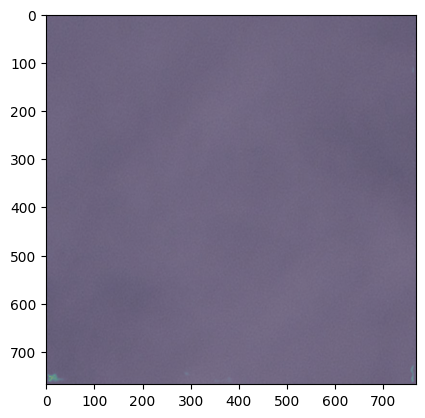

In [13]:
SKIP = 1

item = train_ds.skip(SKIP).take(1)
p = model.predict(item)

for item, label in train_ds.unbatch().skip(SKIP).take(1):
    plot_ds_element(item, p[0])